In [ ]:
import cv2
from PIL import Image
import numpy as np
from skimage import filters, measure, morphology, segmentation
from IPython.display import display

def sharpen_edges(image_path, show_image=False):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if show_image:
        colored_image = cv2.applyColorMap(image, cv2.COLORMAP_INFERNO)[:, :, ::-1]
        display(Image.fromarray(colored_image))

    # Apply a Gaussian filter to the image to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 1)
    # Calculate the edge map using the Laplacian of Gaussian (LoG) method
    edge_map = filters.laplace(blurred)
    print(edge_map)
    # Convert the edge map to an 8-bit unsigned integer format
    edge_map_uint8 = np.uint8(np.round(edge_map))

    # Threshold the edge map to obtain a binary image
    _, binary_edges = cv2.threshold(edge_map_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Perform morphological operations to clean up the binary image
    footprint = morphology.disk(3)
    cleaned_edges = morphology.closing(binary_edges, footprint=footprint)
    cleaned_edges = morphology.opening(cleaned_edges, footprint=footprint)

    # Create a mask using the cleaned-up edge map
    mask = np.zeros_like(image)
    mask[cleaned_edges == 255] = 255
    

    # Apply the mask to the original image
    sharpened_image = image.copy()
    sharpened_image[mask == 0] = blurred[mask == 0]

    if show_image:
        display(cleaned_edges[cleaned_edges != 0])
        display(Image.fromarray(edge_map_uint8))
        display(Image.fromarray(cleaned_edges-image))
        colored_image = cv2.applyColorMap(sharpened_image, cv2.COLORMAP_INFERNO)[:, :, ::-1]
        display(Image.fromarray(colored_image))
    return sharpened_image

# Example usage:
image_path = "Results/model_depth_anything/D1/predicted_depth/T_S03116.png"
sharpened_image = sharpen_edges(image_path=image_path, show_image=True)

In [ ]:
import cv2
from PIL import Image
import numpy as np
from IPython.display import display

def display_colored(image):
    colored_image = cv2.applyColorMap(image, cv2.COLORMAP_INFERNO)[:, :, ::-1]
    display(Image.fromarray(colored_image))

def sharpen_edges(image_path, show_image=False):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if show_image:
        colored_image = cv2.applyColorMap(image, cv2.COLORMAP_INFERNO)[:, :, ::-1]
        display(Image.fromarray(colored_image))

    # Apply a Gaussian filter to the image to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Detect edges using the Canny edge detector
    edges = cv2.Canny(image, 30, 40)

    # Create a mask using the cleaned-up edge map
    mask = np.zeros_like(image)
    mask[edges != 0] = 255

    # Apply the mask to the original image
    sharpened_image = image.copy()
    # Create a sharpening kernel
    kernel = np.array([[-1,-1,-1],
                    [-1,9,-1],
                    [-1,-1,-1]])

    # Apply the sharpening kernel to the image
    sharpened_image = cv2.filter2D(sharpened_image, -1, kernel)
    
    blurred[mask!=0] = sharpened_image[mask!=0]
    sharpened_image = blurred

    if show_image:
        display(Image.fromarray(mask))
        colored_image = cv2.applyColorMap(sharpened_image, cv2.COLORMAP_INFERNO)[:, :, ::-1]
        display(Image.fromarray(colored_image))

    return sharpened_image

# Example usage:
image_path = "Results/model_depth_anything/D1/predicted_depth/T_S03116.png"
sharpened_image_canny = sharpen_edges(image_path=image_path, show_image=True)

(384, 576)
(384, 576, 3)


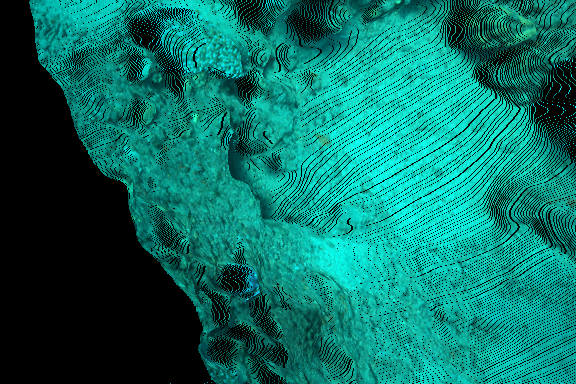

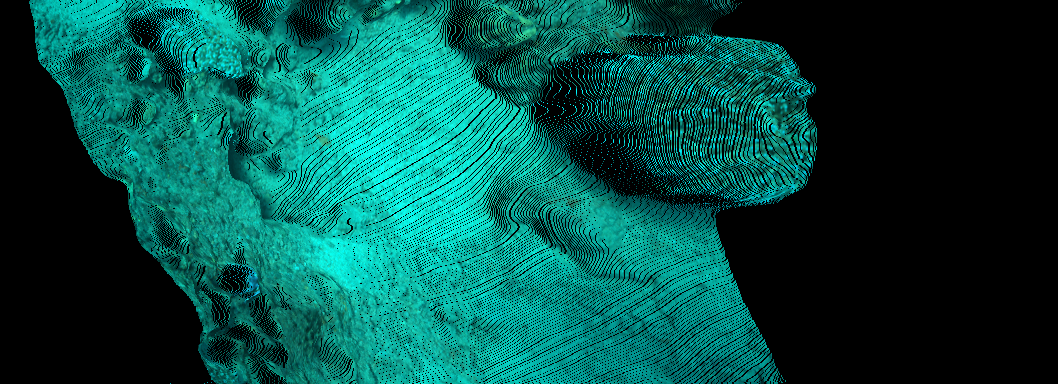

In [75]:
import cv2
import numpy as np
from PIL import Image
import rawpy
import torch
import torch.nn.functional as F
import tifffile as tiff

def warp_stereo_image_1(stereo_image, disparity, scalingfactor=20):
    """
    Warps the left image to the right image based on the disparity map.
    :param stereo_image: A numpy array of shape (height, width, 3) representing the stereo image.
    :param disparity: A numpy array of shape (height, width) representing the disparity map.
    :return: A numpy array of shape (height, width, 3) representing the warped image.
    """
    height, width = disparity.shape
    warped_image = np.zeros_like(stereo_image)

    for y in range(height):
        for x in range(width):
            # Compute the new x-coordinate based on the disparity map
            new_x = x + int(disparity[y, x]/scalingfactor)
            # new_x = int(((new_x/(width-1))-0.5)*2)
            if new_x >= 0 and new_x < width:
                # Copy the pixel from the left image to the warped image
                warped_image[y, new_x] = stereo_image[y, x]

    return warped_image

def warp_stereo_image(stereo_image, disparity, scalingfactor=20):
    """
    Warps the left image to the right image based on the disparity map.
    :param stereo_image: A numpy array of shape (height, width, 3) representing the stereo image.
    :param disparity: A numpy array of shape (height, width) representing the disparity map.
    :return: A numpy array of shape (height, width, 3) representing the warped image.
    """
    height, width = disparity.shape
    max_disparity = np.max(disparity)
    max_shift = int(max_disparity/scalingfactor)
    new_width = width + 2*max_shift
    warped_image = np.zeros((height, new_width, 3), dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            # Compute the new x-coordinate based on the disparity map
            new_x = x + int(disparity[y, x]/scalingfactor)
            # Copy the pixel from the left image to the warped image
            warped_image[y, new_x] = stereo_image[y, x]

    # Crop the warped image to remove empty bits on the edges
    # warped_image = warped_image[:, max_shift:max_shift+width]

    return warped_image


def warp_stereo_image_2(stereo_image, depth, scalingfactor=20):
    """
    Warps the left image to the right image based on the disparity map.
    :param stereo_image: A numpy array of shape (height, width, 3) representing the stereo image.
    :param disparity: A numpy array of shape (height, width) representing the disparity map.
    :return: A numpy array of shape (height, width, 3) representing the warped image.
    """
    height, width = depth.shape
    max_disparity = np.min(disparity)
    max_shift = int(max_disparity/scalingfactor)
    new_width = width + 2*max_shift
    warped_image = np.zeros((height, new_width, 3), dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            # Compute the new x-coordinate based on the disparity map
            new_x = x + int(disparity[y, x]/scalingfactor)
            # Copy the pixel from the left image to the warped image
            warped_image[y, new_x] = stereo_image[y, x]

    # Crop the warped image to remove empty bits on the edges
    # warped_image = warped_image[:, max_shift:max_shift+width]

    return warped_image


image_path = "Datasets/D1/Raw/T_S03116.ARW"
depth_path = "Datasets/D1/Depth/depthT_S03116.TIF"
disparity_path = "Results/model_depth_anything/D1/predicted_depth/T_S03116.png"
disparity = cv2.imread(disparity_path, cv2.IMREAD_GRAYSCALE)
print(disparity.shape)
image_dim = (576,384)
depth = tiff.imread(depth_path)
with rawpy.imread(image_path) as raw_image:
    rgb = raw_image.postprocess()
    image = Image.fromarray(rgb)
    # print(f"Original image size: {w}x{h}")
    # print(f"Resized image size: {width}x{height}")
    image = image.resize(image_dim)
    image = np.array(image)
    print(image.shape)

warped_image_1 = warp_stereo_image_1(image, disparity, scalingfactor=1)
display(Image.fromarray(warped_image_1))
warped_image = warp_stereo_image(image, disparity, scalingfactor=1)
display(Image.fromarray(warped_image))

# warped_image = warp_stereo_image(image, sharpened_image)
# display(Image.fromarray(warped_image))


# warped_image = warp_stereo_image(image, sharpened_image_canny)
# display(Image.fromarray(warped_image))

# warped_image = warp_stereo_image(image, sharpened_image_canny, scalingfactor=1)
# display(Image.fromarray(warped_image))


contours


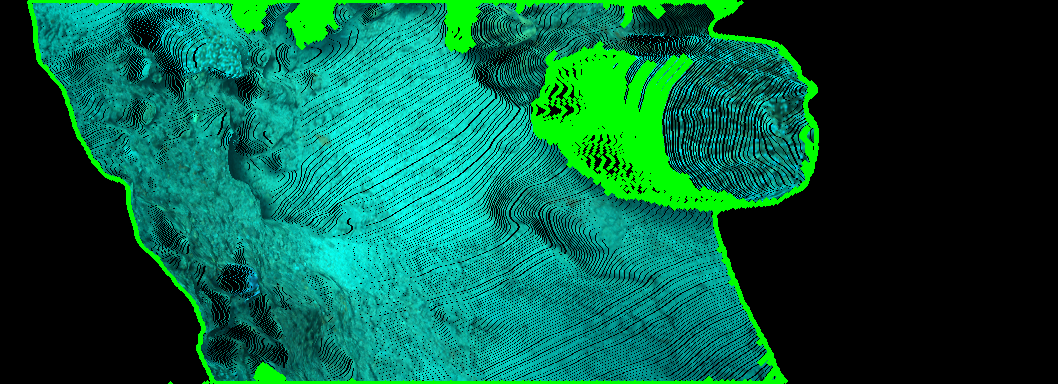

cropped to the largest contour


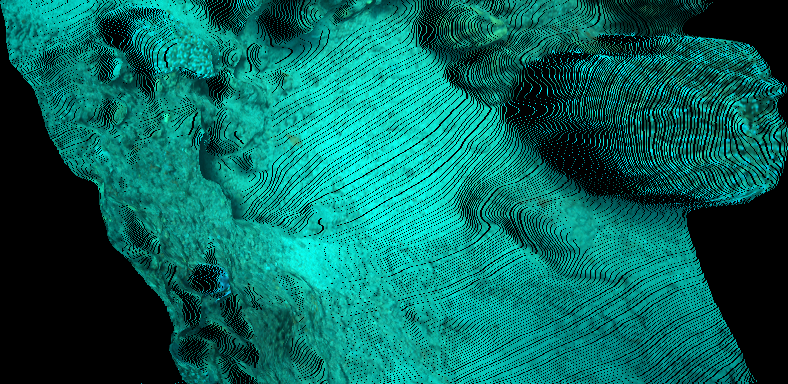

cropped to the center to original dimensions


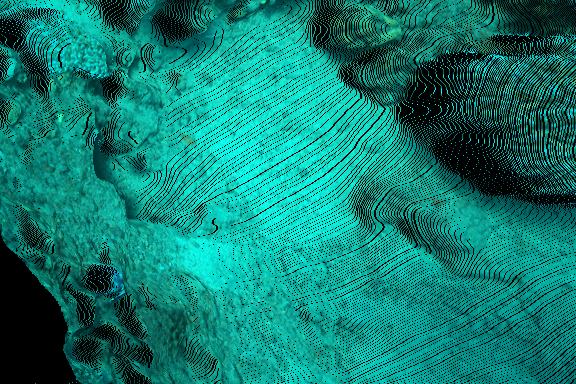

In [77]:
def crop_image(image, image_dim=image_dim):
    
    def crop_center(image, target_height, target_width):
        # Get the dimensions of the original image
        image_height, image_width = image.shape[:2]

        # Calculate the starting point for the crop
        start_x = max(0, (image_width - target_width) // 2)
        start_y = max(0, (image_height - target_height) // 2)

        # Calculate the end point for the crop
        end_x = min(image_width, start_x + target_width)
        end_y = min(image_height, start_y + target_height)

        # Perform the crop
        cropped_image = image[start_y:end_y, start_x:end_x]

        return cropped_image
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find contours of non-black regions
    contours, _ = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # display the contours
    
    contours_image = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 3)

    print("contours")
    display(Image.fromarray(contours_image))
    # Get bounding box of the largest contour
     
    # Sort contours by area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    x, y, w, h = cv2.boundingRect(contours[0])
    # Crop the image using the bounding box
    cropped_image = image[y:y+h, x:x+w]

    print("cropped to the largest contour")
    display(Image.fromarray(cropped_image))
    cropped_image = crop_center(cropped_image, image_dim[1], image_dim[0])
    print("cropped to the center to original dimensions")
    display(Image.fromarray(cropped_image))
    return cropped_image

cropped_image = crop_image(warped_image)

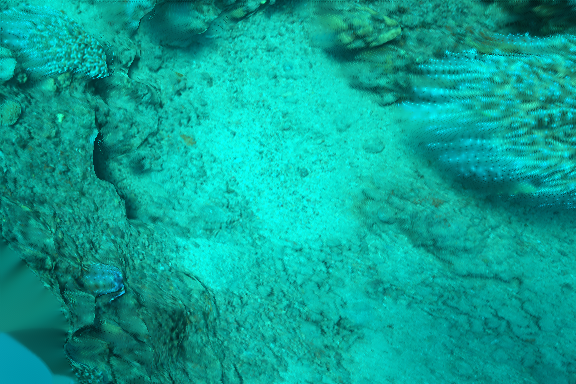

In [116]:
# Create a mask where black pixels are set to 1
mask = np.all(cropped_image == [0, 0, 0], axis=-1).astype(np.uint8)

# Inpaint damaged region using Exemplar-based inpainting
inpainted_img = cv2.inpaint(cropped_image, mask, inpaintRadius=4, flags=cv2.INPAINT_TELEA)

# Display inpainted image
display(Image.fromarray(inpainted_img))

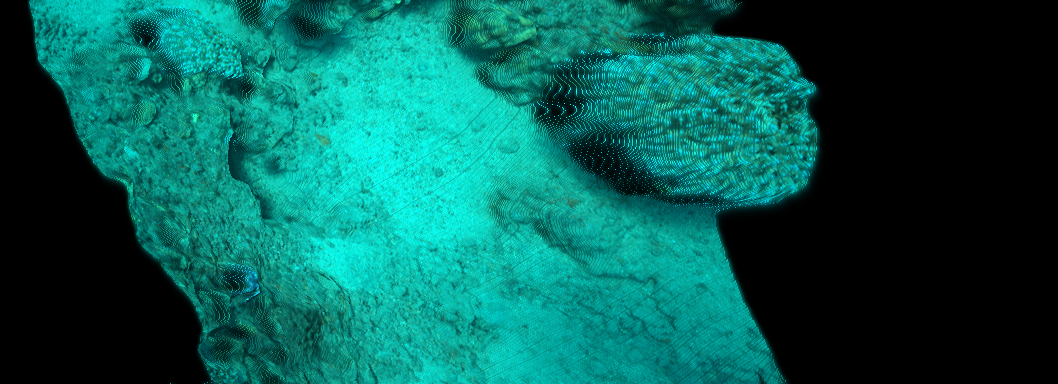

In [53]:
# fill black pixels with the average of the surrounding pixels
def fill_black_pixels(image, count=1, kernel_half_size=3):
    """
    Fills black pixels in the image with the average of the surrounding pixels.
    :param image: A numpy array of shape (height, width, 3) representing the image.
    :return: A numpy array of shape (height, width, 3) representing the image with black pixels filled in.
    """
    # Create a copy of the image
    filled_image = image.copy()
    for i in range(count):
        # Iterate over each pixel in the image
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                # If the pixel is black, fill it in with the average of the surrounding pixels
                if np.all(filled_image[y, x] == 0):
                    # Calculate the average of the surrounding pixels
                    surrounding_pixels = []
                    for dy in range(-kernel_half_size, kernel_half_size):
                        for dx in range(-kernel_half_size, kernel_half_size):
                            if y + dy >= 0 and y + dy < image.shape[0] and x + dx >= 0 and x + dx < image.shape[1]:
                                surrounding_pixels.append(filled_image[y + dy, x + dx])
                    surrounding_pixels = np.array(surrounding_pixels)
                    average_pixel = np.mean(surrounding_pixels, axis=0)

                    # Fill in the black pixel with the average of the surrounding pixels
                    filled_image[y, x] = average_pixel

    return filled_image

filled_image = fill_black_pixels(warped_image, kernel_half_size=3, count=1)
display(Image.fromarray(filled_image))

contours


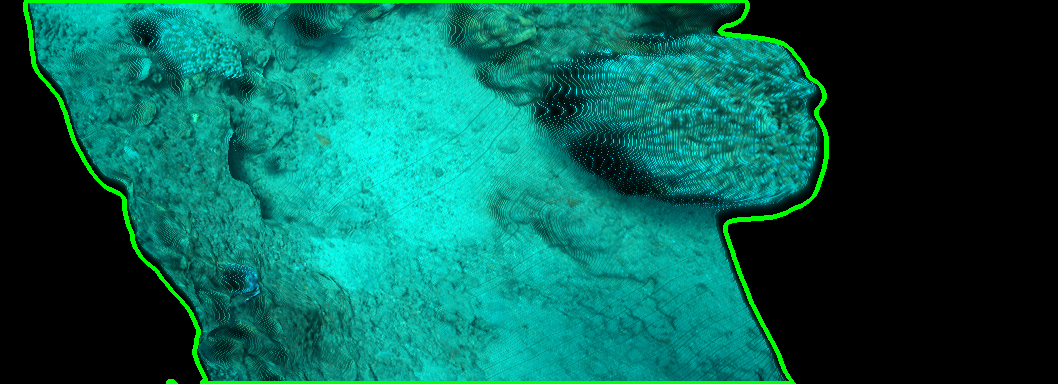

cropped to the largest contour


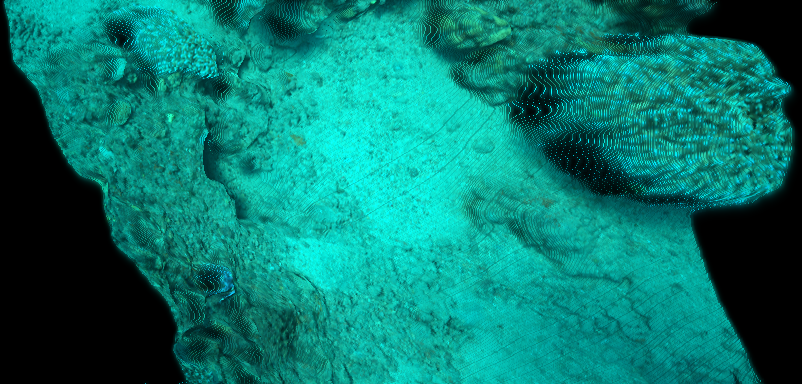

cropped to the center to original dimensions


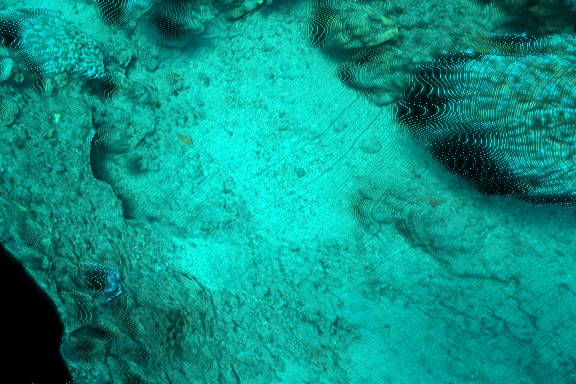

In [85]:
cropped_image_filled = crop_image(filled_image)

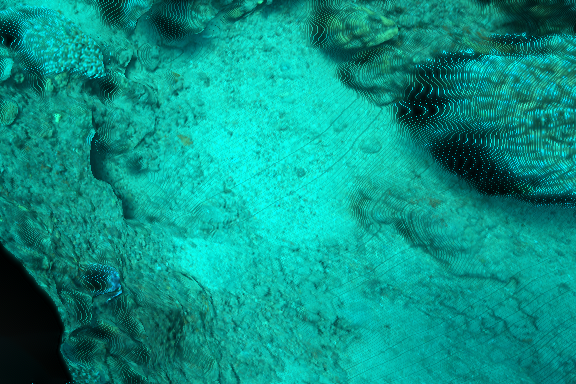

In [96]:
# Create a mask where black pixels are set to 1
mask = np.all(cropped_image_filled == [0, 0, 0], axis=-1).astype(np.uint8)

# Inpaint damaged region using Exemplar-based inpainting
inpainted_img = cv2.inpaint(cropped_image_filled, mask, inpaintRadius=4, flags=cv2.INPAINT_TELEA)

# Display inpainted image
display(Image.fromarray(inpainted_img))

In [112]:
import torch
from diffusers import StableDiffusionDepth2ImgPipeline
from diffusers.utils import load_image, make_image_grid


pipeline = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    torch_dtype=torch.float16,
    use_safetensors=True,
)
prompt = "stereo image pair"
negative_prompt = ""
generated_image = pipeline(prompt=prompt, image=image, negative_prompt=negative_prompt, depth_map = depth  ,strength=0.7).images[0]
make_image_grid([image, generated_image], rows=1, cols=2)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

RuntimeError: "LayerNormKernelImpl" not implemented for 'Half'